In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit

def sigmoid(x, slope, bias):
    return expit((x + bias) * slope)

# Bee physics from Stone but with cos, sin instead of sin, cos
def rotate(dt, theta, r):
    """Return new heading after a rotation around Z axis."""
    return (theta + r * dt + np.pi) % (2.0 * np.pi) - np.pi


def thrust(dt, theta, acceleration):
    """Thrust vector from current heading and acceleration

    theta: clockwise radians around z-axis, where 0 is forward
    acceleration: float where max speed is ....?!?
    """
    return np.array([np.cos(theta), np.sin(theta)]) * acceleration * dt


def get_next_state(dt, heading, velocity, rotation, acceleration, drag=0.5):
    """Get new heading and velocity, based on relative rotation and
    acceleration and linear drag."""
    theta = rotate(dt, heading, rotation)
    v = velocity + thrust(dt, theta, acceleration)
    v *= (1.0 - drag)**dt
    return theta, v


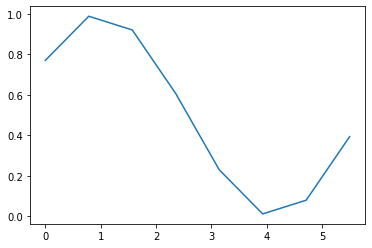

In [2]:
N_COLUMNS = 8
x = np.linspace(0, np.pi*2, N_COLUMNS, endpoint = False)

from scipy.interpolate import interp1d
tb1_shape = interp1d(np.linspace(0, np.pi*4, N_COLUMNS*2, endpoint=False), np.tile([
          0.053115546224865876,
          0.21157114465228152,
          0.46776426992930864,
          0.49429648559346473,
          1.0,
          1.0,
          0.6612836076144025,
          0.043984481253797114
        ], 2))

def heading_bump(theta, scale = 1.0):
    # Centered around 0.5
    return 0.5 + 0.5 * scale * (np.cos(x - theta))
    return 0.5 + (tb1_shape((x - (theta - 3.5)) % (np.pi*2)) - 0.5)*scale

    

# Simplified model memory columns with only one population.
# Let weights simply encode a simple desired head direction
# (that would have been built up during movement):

home_direction = 1.0 # rad
weights = heading_bump(home_direction, 1.0)

plt.plot(x, weights)

# Let TB1 encode 

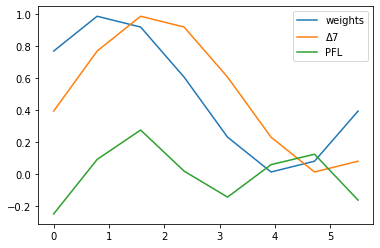

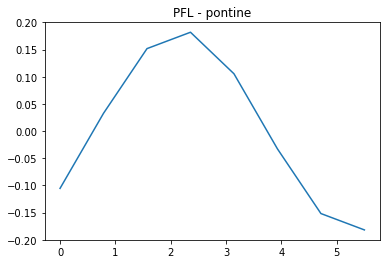

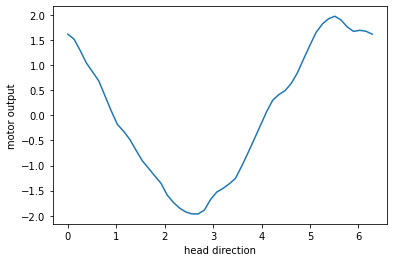

In [10]:
# Some arbitrary heading for testing:
heading = 1 + np.pi/4

weights_left = heading_bump(home_direction - np.pi/4, 1.2)
weights_right = heading_bump(home_direction + np.pi/4, 1.2)

def calculate_rotation(heading, plastic=False):
    global weights_left
    global weights_right
    # Let Delta7 encode current head direction:
    delta7 = heading_bump(heading)
    
    # (LNO - Delta7)
    I = 1 - delta7 # (assume we're always travelling in the head direction with constant speed)
    
    # Shift left and right, corresponding to optimal optic flow expansion for LNO
    pfn_left = I#np.roll(I, -1)
    pfn_right = I#np.roll(I, 1)
    
        
    # Use weights for PFL input. The post-synaptic activity is not the home vector
    # itself, but will be phase-shifted depending on how in line the home vector
    # is with the current heading.
    left = weights_left * pfn_left
    right = weights_right * pfn_right
    
    # Update weights with input:
    if plastic:
        weights_left += (pfn_left - 0.125 * 4) * 0.0025
        weights_right += (pfn_right - 0.125 * 4) * 0.0025
    
    pontine_left = np.roll(left, 4)
    pontine_right = np.roll(right, 4)
    
    # If we shift the input one column to the left and to the right respectively,
    # they will be differently inhibited by the Delta7 bump. The difference in
    # total activity can thus drive steering.
    pfl_left = np.roll(left, -1) - pontine_left
    pfl_right = np.roll(right, 1) - pontine_right
    motor = np.sum(np.clip(pfl_right - delta7, 0, 1000)) - np.sum(np.clip(pfl_left - delta7, 0, 1000))
    
    # When Delta7 is misaligned with weights, I is more aligned with the weights,
    # and attenuation will be small. The output should thus trigger turning:
    #normalized = np.clip(pfl - np.roll(pfl, 4), 0, 1)
    #motor = np.sum(normalized) #np.sum(delta7 - normalized)
    #motor = sigmoid(motor, 10, -1.25)
    #motor = np.sum() #) / 2 + 0.5
    
    #motor = sigmoid(motor, 1, -0.5) - 0.5
    #motor = motor**3 / 6
    
    return motor, pfl_left, pfl_right


motor, pfl_left, pfl_right, = calculate_rotation(heading)

plt.plot(x, weights, label="weights")
plt.plot(x, heading_bump(heading), label="$\Delta 7$")
plt.plot(x, pfl_right, label="PFL")
#plt.plot(x, pfl_right - np.roll(pfl_right, 4), label="PFL - pontine")
#plt.plot(x, heading_bump(heading) - pfl, label="diff")
plt.legend()
plt.show()

plt.figure()
plt.title("PFL - pontine")
plt.plot(x, np.clip(pfl_right - np.roll(pfl_right, 4), -1, 1), label="PFL - pontine")
plt.show()

plt.figure()
headings = np.linspace(0, np.pi*2)
motor = np.array([calculate_rotation(h)[0] for h in headings])
plt.plot(headings, motor)
#plt.plot(headings, sigmoid(motor, 30, -0.1))
plt.xlabel("head direction")
plt.ylabel("motor output")
plt.show()

~~Note how the turn strength is strongest when aligned exactly in the wrong direction.~~

**IDEA**: when not aligned, the attenuation would presumably change the phase. Can that be used to figure out alignment?

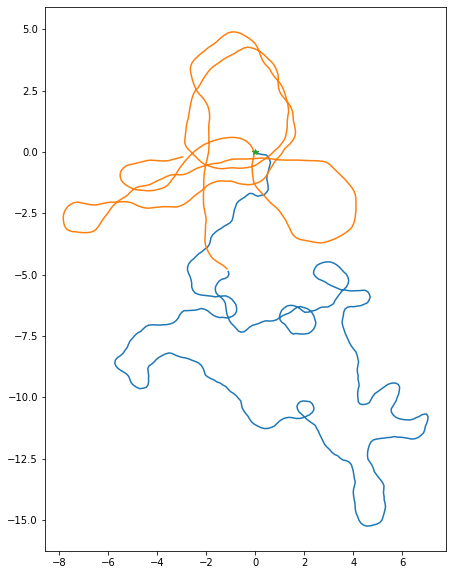

In [17]:
weights_left = np.ones(N_COLUMNS) * 0.5 #heading_bump(home_direction, 1.0)
weights_right = np.ones(N_COLUMNS) * 0.5

path = []

heading = np.random.uniform(0, np.pi*2)
velocity = np.array([0.0, 0.0])
position = np.array([0.0, 0.0])
path.append(position)

window = [0, 1]
window_size = 10

home_after = 500

weights_after_outbound = None

for i in range(1000):
    motor, _, _ = calculate_rotation(heading, plastic=True)
    
    homing = i > home_after
    if homing:
        if weights_after_outbound is None:
            weights_after_outbound = np.copy(weights)
        motor = 2.0 * (motor + np.random.normal(0, 0.1))
    else:
        motor = np.random.normal(0, 0.5)

    heading, velocity = get_next_state(1.0, heading, velocity, motor, 0.15)
    position = position + velocity
    path.append(position)
    
path = np.array(path)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes()
ax.plot(path[:home_after,0], path[:home_after,1])
ax.plot(path[home_after:,0], path[home_after:,1])
ax.set_aspect(1)

# 1 - TB1 accumulates with gain of 0.01, so radius is 100:
#ax.plot(10 * np.cos(home_direction), 10 * np.sin(home_direction), "*")
ax.plot(0, 0, "*")

#ax.quiver(0, 0, np.cos(home_direction), np.sin(home_direction))
plt.show()


**IDEA**: when not aligned, the attenuation would presumably change the phase. Can that be used to figure out alignment?

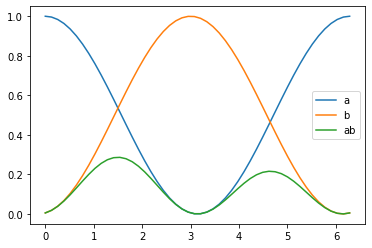

In [539]:
a = 0.5 * (np.cos(headings) + 1.0)
b = 0.5 * (np.cos(headings - 3) + 1.0)
plt.plot(headings, a, label="a")
plt.plot(headings, b, label="b")
plt.plot(headings, a * b, label="ab")
plt.legend()
plt.show()